**<h1><center>Digit Recognizer</center></h1>**
*<h3><center>Mathan Raj O</center></h3>*
*<h3><center>06/05/2020</center></h3>*

Importing Libraries

In [175]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


## Table of Contents

<div  style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Introduction</a><br>

2. <a href="#item2">Data</a><br>

3. <a href="#item3">Data Preprocessing</a><br>

4. <a href="#item4">Exploratory Data Analysis</a><br>

5. <a href="#item5">Model</a><br>

6. <a href='#item6'>Prediction</a>

</font>
</div>

<a id='item1'></a>

**1.Introduction**

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

The objective is to correctly identify digits from a dataset of tens of thousands of handwritten images

<a id='item2'></a>

**2.Data**

In [131]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

In [132]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [134]:
df.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


(None, None)

Training Images = 42000
Testing Images = 28000

In [ ]:
df['label'].value_counts()

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image

<a id='item3'></a>

**3.Data Preprocessing**

Splitting the label and the pixel values

In [ ]:
training_label = df['label'].values


Reshaping the 784 pixel values in to 28*28 array

In [ ]:
training_images = df.iloc[:,1:].values
testing_images = df_test.values

In [ ]:
training_images.shape,testing_images.shape


In [135]:
training_images = training_images.reshape(training_images.shape[0],28,28,1)
testing_images = testing_images.reshape(testing_images.shape[0],28,28,1)

In [138]:
training_images = training_images/255.0
testing_images = testing_images/255.0

In [136]:
training_images.shape,testing_images.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

<a id ='item4'></a>

**4.Exploratory Data Analysis**

Checking the training images

In [ ]:
fig,axes=plt.subplots(4,4,figsize=(8,8))
m=0
for i in range(4):
    for j in range(4):
        axes[i][j].imshow(np.squeeze(training_images[m],axis=2),cmap=plt.cm.binary)
        axes[i][j].xaxis.set_visible(False)
        axes[i][j].yaxis.set_visible(False)
        m+=1
plt.show()
        
    


<a id='item5'></a>

**5.Model**

In [ ]:
target_acc = 1
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        if logs['accuracy'] and logs['val_accuracy']>=target_acc:
            self.model.stop_training=True
            print('Reached {} Model Accuracy'.format(target_acc))

In [402]:
model = Sequential([Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1),padding='same'),
                   MaxPooling2D((2,2),padding='same'),
                   BatchNormalization(),
                   Conv2D(64,(3,3),activation='relu',padding='same'),  
                   MaxPooling2D((2,2),padding='same'),
                   BatchNormalization(),
                   Conv2D(64,(3,3),activation='relu',padding='same'),  
                   MaxPooling2D((2,2),padding='same'),
                   BatchNormalization(),
                   Conv2D(128,(3,3),activation='relu',padding='same'),
                   MaxPooling2D((2,2),padding='same'),
                   BatchNormalization(),
                   Flatten(),
                   Dense(512,'relu'),
                   BatchNormalization(),
                   Dropout(0.3),
                   Dense(10,'softmax')
                   ])
model.compile(optimizer=RMSprop(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Image Augumentation

In [296]:
X_train,X_val,y_train,y_val = train_test_split(training_images,training_label,test_size=0.3,random_state=42)
X_train.shape,y_train.shape

((29400, 28, 28, 1), (29400,))

In [297]:
y_train =tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)

In [403]:
training_generator = ImageDataGenerator(rotation_range=8, width_shift_range=0.08,
                               height_shift_range=0.08)
training_generator.fit(X_train)
training_data = training_generator.flow(X_train,y_train,batch_size=64)


In [362]:
# EPOCHS=15
# lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, min_delta=0.000001, patience=1, verbose=1)
# history = model.fit(training_images,training_label,validation_split=0.3,epochs=EPOCHS,callbacks=[lr_reduce])


Model Training using Augumented Data

In [405]:
EPOCHS=5
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, min_delta=0.000001, patience=1, verbose=1)
history = model.fit_generator(training_data,validation_data=(X_val,y_val),epochs=EPOCHS,callbacks=[lr_reduce])

Train for 460 steps, validate on 12600 samples
Epoch 1/5
460/460 [==============================] - 15s 33ms/step - loss: 0.0122 - accuracy: 0.9963 - val_loss: 0.0182 - val_accuracy: 0.9948
Epoch 2/5
459/460 [============================>.] - ETA: 0s - loss: 0.0122 - accuracy: 0.9961
Epoch 00002: ReduceLROnPlateau reducing learning rate to 2.560000284574926e-05.
460/460 [==============================] - 14s 30ms/step - loss: 0.0122 - accuracy: 0.9961 - val_loss: 0.0178 - val_accuracy: 0.9947
Epoch 3/5
460/460 [==============================] - 14s 30ms/step - loss: 0.0103 - accuracy: 0.9972 - val_loss: 0.0181 - val_accuracy: 0.9948
Epoch 4/5
459/460 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.9967
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0240000847261399e-05.
460/460 [==============================] - 14s 30ms/step - loss: 0.0109 - accuracy: 0.9967 - val_loss: 0.0182 - val_accuracy: 0.9948
Epoch 5/5
460/460 [==============================]

In [317]:
y_val_pred[0],np.argmax(y_val[0])

(8, 8)

In [406]:
y_val_pred = model.predict_classes(X_val)

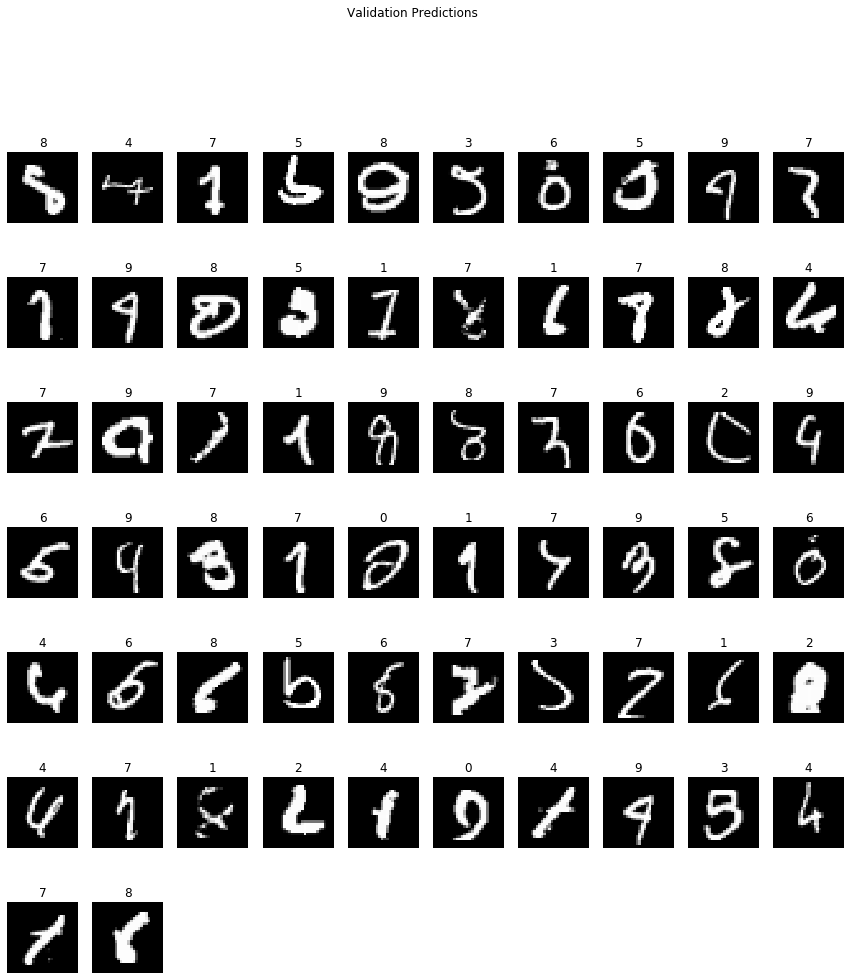

In [407]:
k=1
plt.figure(figsize=(15,18))
for i in range(len(y_val_pred)):
    if(y_val_pred[i]!=np.argmax(y_val[i])):
        plt.subplot(8,10,k)
        plt.imshow(np.squeeze(X_val[i],axis=2),cmap='gray')
        plt.title(y_val_pred[i])
        plt.axis('off')
        k+=1
        plt.suptitle('Validation Predictions')
    

In [408]:
val_loss,val_score = model.evaluate(X_val,y_val)
val_loss, val_score

12600/12600 [==============================] - 1s 116us/sample - loss: 0.0180 - accuracy: 0.9951


(0.017963620628771524, 0.99507934)

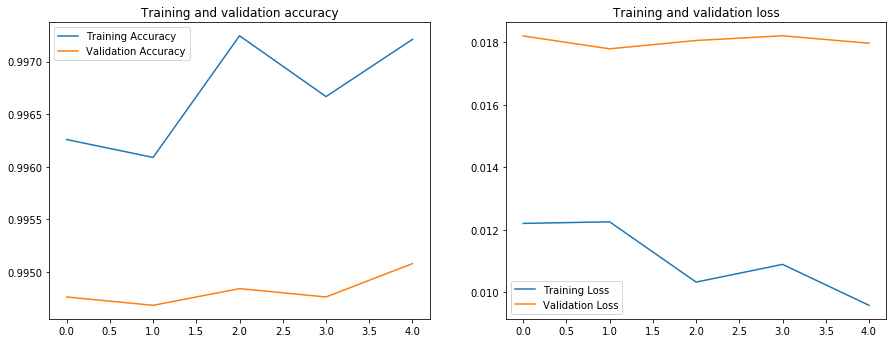

In [409]:
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']
epoch = range(EPOCHS)
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.plot(epoch,training_accuracy,label='Training Accuracy')
plt.plot(epoch,validation_accuracy,label='Validation Accuracy')
plt.legend()
plt.title('Training and validation accuracy')
plt.subplot(222)
plt.plot(epoch,training_loss,label='Training Loss')
plt.plot(epoch,validation_loss,label='Validation Loss')
plt.legend()
plt.title('Training and validation loss')
plt.show()

<a id='item6'></a>

**6.Prediction**

In [410]:
y_pred = model.predict_classes(testing_images)

In [ ]:
y_pred

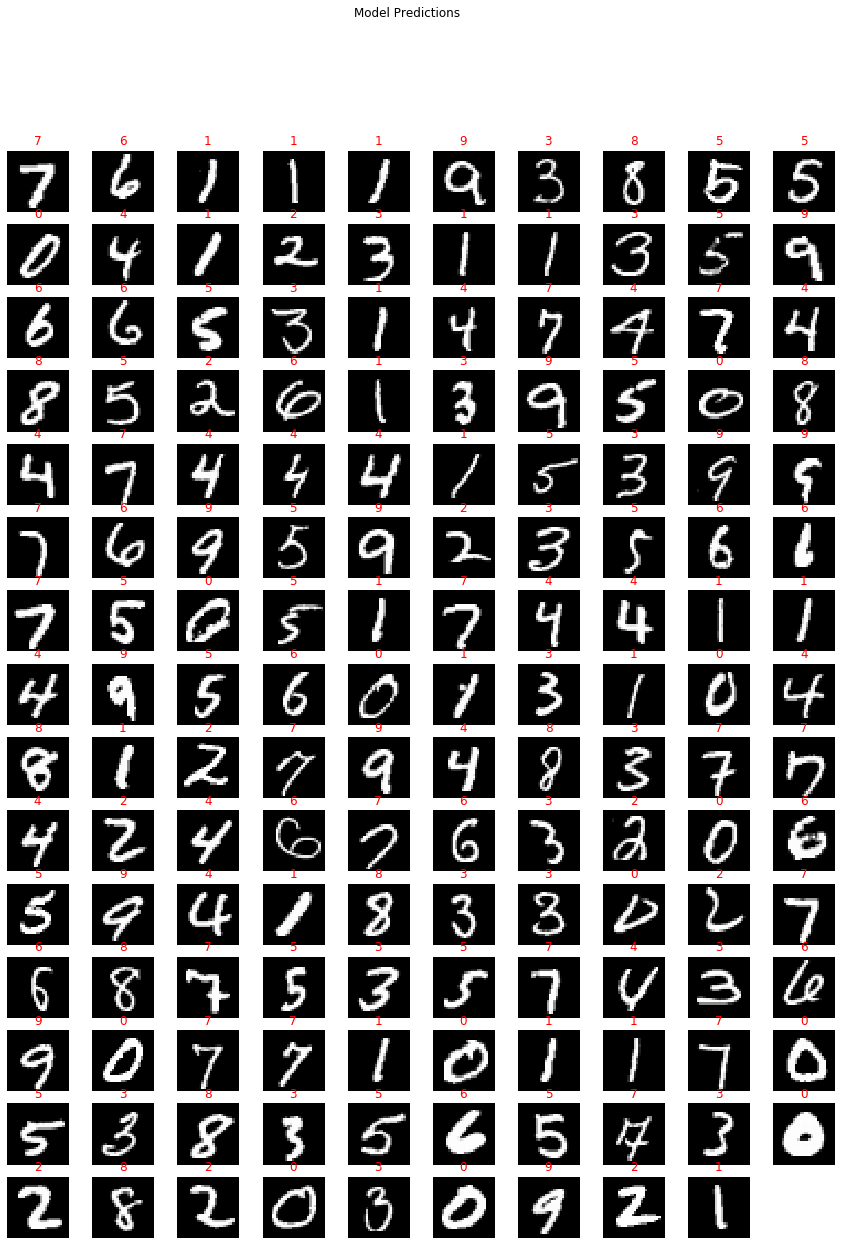

In [411]:
plt.figure(figsize=(15,20))
for i in range(1,150,1):
    plt.subplot(15,10,i)
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.imshow(np.squeeze(testing_images[400+i],axis=2),cmap='gray')
    plt.title(y_pred[400+i], color='red')
    plt.axis('off')
    plt.suptitle('Model Predictions')
    


In [ ]:
len(y_pred)

In [412]:
submission['Label']=y_pred

In [252]:
submission.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [414]:
submission.to_csv('submission.csv',index=False)